In [17]:
# Load packages
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [18]:
# get week dataframe
def load_week_df(week):
    df = pd.read_csv('../data/week{:.0f}.csv'.format(week))
    return df

week = 1
week_df = load_week_df(week)

In [19]:
# get play dataframe
def get_play_df(week_df, play_id_list, play_idx):
    play_sel = (week_df["playId"] == play_id_list[play_idx]) # play selector
    play_df = week_df[play_sel]
    return play_df

play_idx = 0
play_id_list = np.unique(week_df["playId"])
play_df = get_play_df(week_df, play_id_list, play_idx)

In [20]:
defense_positions = np.array(['CB','DB','DE','DL','FS','ILB','LB','MLB','NT','OLB','S','SS'])
offense_positions = np.array(['FB','HB','QB','RB','TE','WR'])

In [21]:
# get frame at which football arrives at receiver
def get_pass_arrival_df(play_df):
    r = re.compile('pass_outcome*') # get all events that start with 'pass_outcome'
    vmatch = np.vectorize(lambda x:bool(r.match(x)))
    sel = vmatch(play_df["event"])
    pass_arrival_df = play_df[sel]
    return pass_arrival_df

# find intended receiver and defender
def get_intended_receiver_and_defender(play_df):
    pass_arrival_df = get_pass_arrival_df(play_df)
    football_df = pass_arrival_df[pass_arrival_df["displayName"] == 'Football']
    football_xy = football_df[["x","y"]].values
    def_sel = pass_arrival_df["position"].apply(lambda x : x in defense_positions)
    off_sel = pass_arrival_df["position"].apply(lambda x : x in offense_positions)
    defense_df = pass_arrival_df[def_sel]
    offense_df = pass_arrival_df[off_sel]
    def_players_xy = defense_df[["x","y"]].values
    off_players_xy = offense_df[["x","y"]].values
    defender_idx = np.argmin(np.linalg.norm(def_players_xy - football_xy,axis=1))
    defender_df = defense_df.iloc[defender_idx]
    receiver_idx = np.argmin(np.linalg.norm(off_players_xy - football_xy,axis=1))
    receiver_df = offense_df.iloc[receiver_idx]
    return receiver_df["displayName"], defender_df["displayName"]

receiver_name, defender_name = get_intended_receiver_and_defender(play_df)
print(receiver_name)
print(defender_name)

Ted Ginn
Carlton Davis


In [22]:
# plot play
def plot_play(play_df, offense_positions, defense_positions):
    fig = plt.figure()
    ax = plt.gca()
    players = np.unique(play_df["displayName"])
    for player in players:
        player_df = play_df[play_df["displayName"] == player]
        x = player_df["x"]
        y = player_df["y"]
        name = player_df["displayName"].iloc[0]
        position = player_df["position"].iloc[0]
        if name == 'Football': # ball (black)
            ax.plot(x, y, color='k', linewidth=2)
        elif player == receiver_name: # intended receiver (cyan)
            ax.plot(x, y, color='c', linewidth=2)
        elif player == defender_name: # defender (magenta)
            ax.plot(x, y, color='m', linewidth=2)
        elif position in defense_positions: # defense (red)
            ax.plot(x, y, color='r', linewidth=2)
        else: # offense (blue)
            ax.plot(x, y, color='b', linewidth=2)
    print(np.unique(play_df["event"][play_df["event"] != "None"])) # print events of play (not in chronological order)

['ball_snap' 'first_contact' 'out_of_bounds' 'pass_arrived' 'pass_forward'
 'pass_outcome_caught']


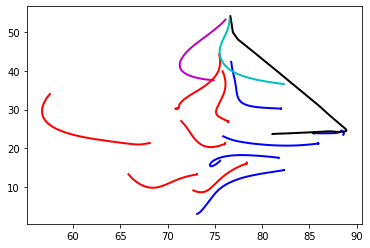

In [23]:
plot_play(play_df, offense_positions, defense_positions)